# Scintillation Detector Signal Types

It is necessary to determine the types of scintillation detector signals.

## Import and data reading

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.patches as mpatches

In [2]:
df = pd.read_csv('data/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)

In [3]:
df.drop([0, 1, 2, 3, 504], axis=1, inplace=True)
df.columns = list(range(500))
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23474,14826,14827,14825,14818,14825,14827,14827,14823,14823,14823,...,14826,14828,14825,14819,14826,14828,14822,14824,14824,14827
23475,14824,14823,14819,14828,14819,14824,14824,14823,14824,14821,...,14828,14826,14824,14814,14814,14818,14816,14822,14819,14817
23476,14822,14822,14824,14820,14823,14828,14823,14824,14820,14824,...,14826,14817,14815,14817,14818,14817,14816,14819,14817,14820
23477,14824,14823,14824,14822,14821,14824,14820,14822,14828,14827,...,14823,14824,14827,14822,14825,14824,14822,14820,14819,14824


Given code for calculating some features

In [4]:
from tqdm import tqdm

def exp_func(x, a, c, d):
    return a*np.exp(-c*x)+d


def exp_fit(signals):
    print('Fitting is starting')
    coeff = []
    error = []
    for num, signal in tqdm(enumerate(signals)):
        x = [i for i in range(1, len(signal) + 1)]
        y = signal
        try:
            popt, pcov = curve_fit(exp_func, x, y, p0=(1, 1e-6, 1))
            coeff.append(popt)
        except RuntimeError:
            error.append(num)
    print('Fitting has ended')
    return coeff, error


def invert(signals):
    return [(np.amax(signal)-np.array(signal) + 2) for signal in signals]


def get_signals(file, step):
    signals_ = []
    print('Signal extraction is starting')
    for row in tqdm(file.itertuples()): 
        values = row[1:]
        index_of_min = np.argmin(values)
        median_level = np.median(values[300:400])
        gap = median_level - values[index_of_min]

        start = 0
        while (values[index_of_min] + step*gap >= values[index_of_min + start]):
            start += 1

        fin = 0
        three_sigma_level = median_level - 3 * np.std(values[300:400], ddof=0)
        three_sigma_rule = True
        try:
            while three_sigma_rule:
                fin += 1
                three_sigma_rule = values[index_of_min + start + fin] <= three_sigma_level
        except KeyError: 
            signals_.append(list(values[index_of_min + start:]))
        else:
            signals_.append(list(values[index_of_min + start:index_of_min + start + fin]))
    print('Signal extraction has ended')

    return signals_


def diff_line_height(coeff, step):
    plt.figure(figsize=(10, 10))
    X = np.array([coeff[i][1] for i in range(len(coeff)) if coeff[i][1]<0.6])
    y_histogram, x_histogram, _ = plt.hist(X, bins=500);
    
    X_plot = np.linspace(0, 0.6, 1000)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.004).fit(X.reshape(-1, 1))
    log_dens = kde.score_samples(X_plot)
    dens_estim = np.exp(log_dens) * max(y_histogram) / max(np.exp(log_dens))
    
    peaks = argrelextrema(dens_estim, np.greater)
    peaks = peaks[0]
    peak_1 = peaks[np.argmax(dens_estim[peaks])]
    peaks = [x for i,x in enumerate(peaks) if i!=np.argmax(dens_estim[(peaks)])]
    peak_2 = peaks[np.argmax(dens_estim[(peaks)])]

    diff = argrelextrema(dens_estim[min(peak_1, peak_2):max(peak_1, peak_2)], np.less)[0][0] + min(peak_1, peak_2)
    
    plt.plot(X_plot[[peak_1, peak_2], 0], dens_estim[[peak_1, peak_2]], 'go', label='modal peak')
    plt.plot(X_plot[[diff], 0], dens_estim[[diff]], 'ro', label='split point: ' + str(dens_estim[diff]))
    plt.plot(X_plot[:, 0], dens_estim, label='gauss kernel density estimation')
    plt.plot([0, 0.6], [50, 50])
    plt.legend(loc='best')
    plt.xlabel('coeff value')
    plt.ylabel('N')
    plt.title('tau histogram for step = ' + str(step))
    
    return dens_estim[diff], x_histogram[int(np.round((x_histogram.shape[0] / dens_estim.shape[0]) * diff))]


def plot_principal_components(data, model, scatter=True, legend=True):
    W_pca = model.components_
    if scatter:
        plt.scatter(data[:,0], data[:,1], .8)
    #plt.plot(data[:,0], -(W_pca[0,0]/W_pca[0,1])*data[:,0], color="c")
    plt.plot(data[:,0], -(W_pca[1,0]/W_pca[1,1])*data[:,0], color="c")
    if legend:
        c_patch = mpatches.Patch(color='c', label='Principal components')
        plt.legend(handles=[c_patch], loc='lower right')
      

def get_signal(row):
    
    extrem = np.argmax(np.array(row))
    level = np.mean(row[:50])
    std = np.std(row[:50])
    
    fl = row[extrem:] < level + 3 * std
    try:
        ind = fl[fl==True].index[0] #  индекс первого элемента, подходящего под условия
    except:
        return False
    
    return row[extrem:ind]   


def get_PSD(signals, short_len, step_from_max):
    PSD = [] 
    for signal in signals:
        short = signal[step_from_max: step_from_max + short_len]
        long = signal[step_from_max:]
        
        short = sum([i for i in short if i>=0])
        long = sum([i for i in long if i>=0])
        
        PSD.append((long - short)/long)
    return PSD


def inv_x(signals):
    return [signals_item * (-1) + max(signals_item) for signals_item in tqdm(signals)]


def normalize(signals):
    return [signal / sum(signal) for signal in signals]

In [5]:
# We calculate tau only in order to determine with which signals there were gaps in the approximation
# We will not consider these signals when splitting, in order to end up with a table with the same order
# and elements for all three methods

step = 0.4
signals = get_signals(df, step)
signals = invert(signals)
coeff, error = exp_fit(signals)

Signal extraction is starting


23479it [00:10, 2205.54it/s]


Signal extraction has ended
Fitting is starting


753it [00:01, 599.72it/s]C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
23479it [00:51, 457.52it/s]

Fitting has ended


In [6]:
# A list of numbered coefficients (to understand which of the original signals were approximated without problems)
length = df.shape[0]
is_error = [1 if i in error else 0 for i in range(length)]
coeff_by_number = []
t = 0
for i in range(length):
    if is_error[i] == 0:
        coeff_by_number.append(coeff[t][1])
        t+=1
    else:
        coeff_by_number.append(-1)

In [7]:
pred_df = pd.DataFrame()
pred_df['coeff'] = coeff_by_number
pred_df['cluster'] = 0
pred_df.loc[((0>pred_df.coeff) | (pred_df.coeff>0.6)), 'cluster'] = 2
        
pred_df.cluster.value_counts()

0    22942
2      537
Name: cluster, dtype: int64

In [8]:
# Creating of the dataframe

nums = np.array([i for i, cff in enumerate(coeff_by_number) if 0<cff<0.6])
B = np.array([cff for i, cff in enumerate(coeff_by_number) if 0<cff<0.6]) 

signals_by_nums = np.array(signals)[nums]

vmax = np.vectorize(max)
vmin = np.vectorize(min)
amp = vmax(signals_by_nums) - vmin(signals_by_nums)

vect_vol = np.vectorize(sum)
vol = vect_vol(signals_by_nums)

feature_df = pd.DataFrame({'B': B,
                           'amp': amp,
                           'vol': vol,
                           'signal': signals_by_nums,
                          'num': nums})

C:\Users\user\AppData\Local\Temp\ipykernel_21764\125345824.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  signals_by_nums = np.array(signals)[nums]


In [9]:
feature_df

,B,amp,vol,signal,num
0,0.284969,271,1168,"[273, 198, 175, 124, 73, 64, 57, 49, 33, 26, 1...",0
1,0.342289,1058,3951,"[1060, 756, 539, 386, 276, 192, 139, 112, 76, ...",1
2,0.360856,1482,5452,"[1484, 1049, 706, 516, 356, 272, 187, 178, 120...",2
3,0.303598,237,1192,"[239, 177, 145, 113, 73, 50, 41, 34, 15, 34, 3...",3
4,0.346242,930,3461,"[932, 646, 451, 320, 236, 198, 161, 95, 60, 56...",4
...,...,...,...,...,...
22937,0.270604,241,977,"[243, 193, 168, 123, 67, 48, 39, 29, 19, 4, 15...",23474
22938,0.275542,3401,17060,"[3403, 2494, 1813, 1428, 1074, 815, 645, 543, ...",23475
22939,0.267431,2621,14666,"[2623, 1866, 1402, 1086, 871, 638, 565, 510, 4...",23476
22940,0.282609,766,4256,"[768, 580, 449, 318, 231, 188, 158, 137, 119, ...",23477


In [10]:
# Creating triples to make it easier to submit data for input to models

nxy = np.array([[i, feature_df.vol[i], feature_df.amp[i], feature_df.num[i]] for i in range(len(feature_df.vol))])

data = np.array([[nxy[:, 1][i], nxy[:, 2][i]] for i in range(len(nxy))])

In [11]:
nxy

array([[    0,  1168,   271,     0],
       [    1,  3951,  1058,     1],
       [    2,  5452,  1482,     2],
       ...,
       [22939, 14666,  2621, 23476],
       [22940,  4256,   766, 23477],
       [22941, 24206,  6205, 23478]])

4.434926001812777


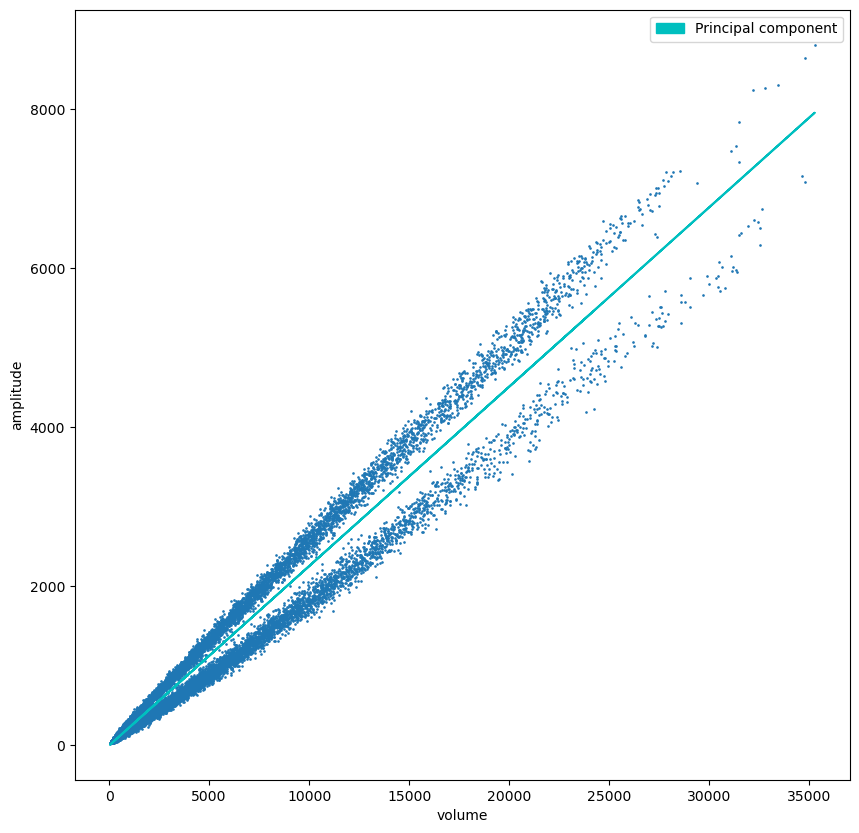

In [12]:
model = PCA(n_components=2)
model.fit(data)


plt.figure(figsize=(10, 10))
plt.scatter(data[:,0], data[:,1], .8)
plt.xlabel('volume')
plt.ylabel('amplitude')


# let's build the components obtained using the PCA method:

# or PCA "goes crazy" when asked to find 2 components in a two-dimensional space
# or sklearn PCA has such a notation, but what obviously should be the first component is in the second place in the array
# see plot_principal_components in utils.py

plot_principal_components(data, model, scatter=False, legend=False)
c_patch = mpatches.Patch(color='c', label='Principal component')
plt.legend(handles=[c_patch])
plt.draw()

print(-1/(model.components_[1,0]/model.components_[1,1]))

22942


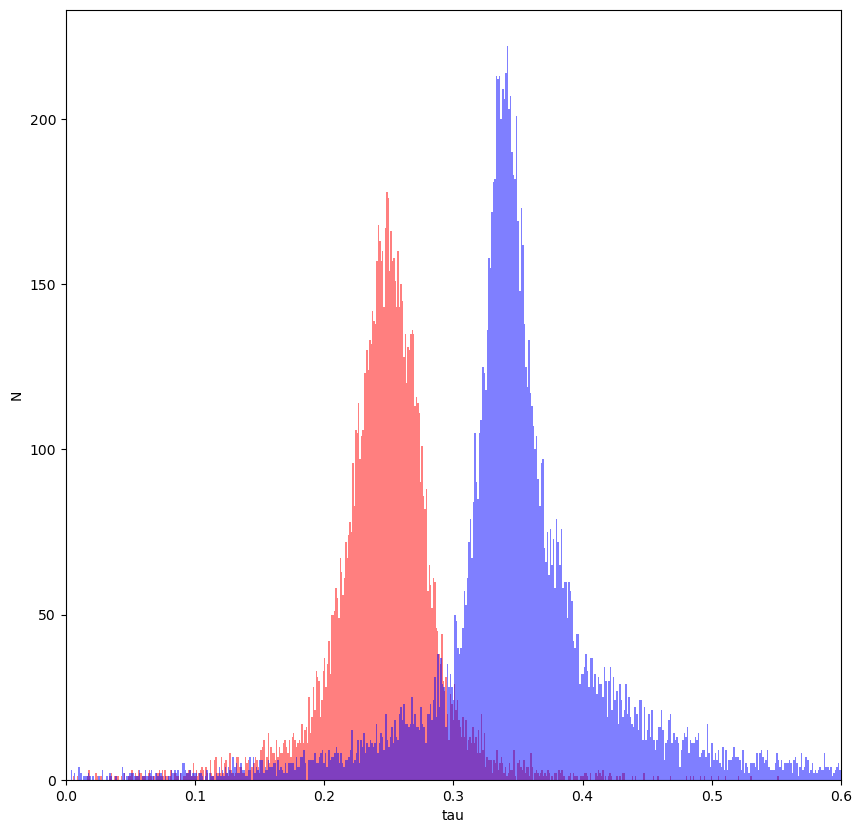

In [13]:
# Check the resulting separation
up, down = [], []
for i in range(len(nxy)):
    if nxy[i][1]/nxy[i][2] <= -1/(model.components_[1,0]/model.components_[1,1]):
        down.append(nxy[i])
    else:
        up.append(nxy[i])


plt.figure(figsize=(10, 10))
plt.hist([feature_df.B[int(up[i][0])] for i in range(len(up))], bins=500, color='r', alpha = 0.5);
plt.hist([feature_df.B[int(down[i][0])] for i in range(len(down))], bins=500, color='b', alpha = 0.5);
plt.xlabel('tau')
plt.ylabel('N')
plt.xlim([0, 0.6])

print(len(nxy))

In [14]:
down[-1]

array([22941, 24206,  6205, 23478])

In [15]:
# We put labels
down_df = pd.DataFrame(down)
down_df[4] = 1

up_df = pd.DataFrame(up)
up_df[4] = 0

In [16]:
feature_df

,B,amp,vol,signal,num
0,0.284969,271,1168,"[273, 198, 175, 124, 73, 64, 57, 49, 33, 26, 1...",0
1,0.342289,1058,3951,"[1060, 756, 539, 386, 276, 192, 139, 112, 76, ...",1
2,0.360856,1482,5452,"[1484, 1049, 706, 516, 356, 272, 187, 178, 120...",2
3,0.303598,237,1192,"[239, 177, 145, 113, 73, 50, 41, 34, 15, 34, 3...",3
4,0.346242,930,3461,"[932, 646, 451, 320, 236, 198, 161, 95, 60, 56...",4
...,...,...,...,...,...
22937,0.270604,241,977,"[243, 193, 168, 123, 67, 48, 39, 29, 19, 4, 15...",23474
22938,0.275542,3401,17060,"[3403, 2494, 1813, 1428, 1074, 815, 645, 543, ...",23475
22939,0.267431,2621,14666,"[2623, 1866, 1402, 1086, 871, 638, 565, 510, 4...",23476
22940,0.282609,766,4256,"[768, 580, 449, 318, 231, 188, 158, 137, 119, ...",23477


In [17]:
up_df

,0,1,2,3,4
0,3,1192,237,3,0
1,5,498,108,5,0
2,6,1746,321,6,0
3,9,4775,878,9,0
4,11,488,103,12,0
...,...,...,...,...,...
10249,22932,9194,1792,23469,0
10250,22935,939,136,23472,0
10251,22938,17060,3401,23475,0
10252,22939,14666,2621,23476,0


In [18]:
down_df

,0,1,2,3,4
0,0,1168,271,0,1
1,1,3951,1058,1,1
2,2,5452,1482,2,1
3,4,3461,930,4,1
4,7,219,53,7,1
...,...,...,...,...,...
12683,22933,22067,5936,23470,1
12684,22934,6301,1577,23471,1
12685,22936,1908,457,23473,1
12686,22937,977,241,23474,1


In [19]:
res_df = pd.concat([up_df, down_df]).sort_values(by=[0]).reset_index(drop=True)
res_df.columns = ['idx', 'amp', 'vol', 'num', 'flag']
res_df

,idx,amp,vol,num,flag
0,0,1168,271,0,1
1,1,3951,1058,1,1
2,2,5452,1482,2,1
3,3,1192,237,3,0
4,4,3461,930,4,1
...,...,...,...,...,...
22937,22937,977,241,23474,1
22938,22938,17060,3401,23475,0
22939,22939,14666,2621,23476,0
22940,22940,4256,766,23477,0


In [20]:
feature_df['flag'] = res_df['flag']

In [21]:
feature_df['flag'].value_counts()

1    12688
0    10254
Name: flag, dtype: int64

In [22]:
pred_df

,coeff,cluster
0,0.284969,0
1,0.342289,0
2,0.360856,0
3,0.303598,0
4,0.346242,0
...,...,...
23474,0.270604,0
23475,0.275542,0
23476,0.267431,0
23477,0.282609,0


In [23]:
oo = {x.num: x.flag for i, x in res_df.iterrows()}
len(oo)

22942

In [30]:
pred_df['index'] = pred_df.index

In [31]:
full = pd.concat([res_df.set_index('num'), pred_df], axis=1)
full.loc[((0>full.coeff) | (full.coeff>0.6)), 'flag'] = 2
full.cluster = full.flag
full.cluster.value_counts()

1.0    12688
0.0    10254
2.0      537
Name: cluster, dtype: int64

In [32]:
true_pred = full[['index', 'cluster']]
true_pred

,index,cluster
0,0,1.0
1,1,1.0
2,2,1.0
3,3,0.0
4,4,1.0
...,...,...
23244,23244,2.0
23268,23268,2.0
23394,23394,2.0
23401,23401,2.0


In [33]:
true_pred = true_pred.sort_values(by=['cluster', 'index'])
true_pred.cluster = true_pred.cluster.astype(int)

In [34]:
# As a result, we get a file with the flags affixed
true_pred.to_csv('principal_distr.csv', index=False)